In [36]:
import pyopencl as cl
import numpy as np
import time
import pyopencl.array as array
import sys
import matplotlib.pyplot as plt
%matplotlib inline


class clCipher:
    def __init__(self):
        """
        Attributes for instance of clModule
        Includes OpenCL context, command queue, kernel code
        and input variables.
        """
        
        # Get platform and device property
        NAME = 'NVIDIA CUDA'
        platforms = cl.get_platforms()
        devs = None
        for platform in platforms:
        	if platform.name == NAME:
        		devs = platform.get_devices()       
        
        # Set up a command queue:
        self.ctx = cl.Context(devs)
        self.queue = cl.CommandQueue(self.ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)
        
        # kernel
        self.kernel_code = """
        //# include<iostream>
        __kernel void Decrypt(__global char* sentence, __global char* decrypted, const unsigned int length){
            unsigned int i = get_global_id(0);
            if(i<length){
                char asc = sentence[i];
                if((asc > 96) && (asc < 123)){
                    if(asc < 110) decrypted[i] = asc+13;
                    else decrypted[i] = asc-13;
                }
                else decrypted[i] = asc;
            }
        }
        """
        
        # Build kernel code
        self.prg = cl.Program(self.ctx, self.kernel_code).build()
        

    def devCipher(self, sentence):
        """
        Function to perform on-device parallel ROT-13 encrypt/decrypt
        by explicitly allocating device memory for host variables.
        Returns
            decrypted :   decrypted/encrypted result
            time_     :   execution time in milliseconds
        """

        # Text pre-processing/list comprehension (if required)
        # Depends on how you approach the problem
        length = len(sentence)*sys.getsizeof(sentence)

        sentence = np.char.asarray(sentence)
        decrypted = np.empty_like(sentence)
        # print(sentence.shape)

        # device memory allocation
        start = time.time()
        sentence_d = array.to_device(self.queue, sentence)
        decrypted_d = array.to_device(self.queue, decrypted)
        
        # Call the kernel function and time event execution
        self.prg.Decrypt(self.queue, (length,), None, sentence_d.data, decrypted_d.data, np.int32(length))

        
        # OpenCL event profiling returns times in nanoseconds. 
        # Hence, 1e-6 will provide the time in milliseconds, 
        # making your plots easier to read.
        self.queue.finish()
        end = time.time()
        # print(decrypted_d)

        # Copy result to host memory
        decrypted = decrypted_d.get()
        decrypted = np.ndarray.tolist(decrypted)
        # print(decrypted)
        # print(type(decrypted))        
        return decrypted[0], end-start

    
    def pyCipher(self, sentence):
        """
        Function to perform parallel ROT-13 encrypt/decrypt using 
        vanilla python. (String manipulation and list comprehension
        will prove useful.)

        Returns
            decrypted                  :   decrypted/encrypted result
            time_    :   execution time in milliseconds
        """
        start = time.time()
        # using ord() convert sting to ascii whose datatype is int
        text_asc = [ord(i) for i in sentence]
        decrypted = ''
        # decrypt
        for asc in text_asc:

            if asc > 96 and asc < 123:
                if asc < 110:
                    # using chr() to convert ascii int to string
                    decrypted += chr(asc+13)
                else:
                    decrypted += chr(asc-13)
            else:
                decrypted += chr(asc)
        # print(decrypted)
        return decrypted, time.time()-start


 

In [38]:
def main():
    # Main code
    # create an instance of clCipher
    cipher = clCipher()

    # Open text file to be deciphered.
    # Preprocess the file to separate sentences
    text_de = open('deciphertext.txt', 'r').read()

    # split string into list populated with '.' as delimiter
    sentences = text_de.split('. ')

    # Loop over each sentence in the list
    decrypted_c = []
    decrypted_p = []
    tc = []
    tp = []
    for sentence in sentences:
        temp_sc, temp_tc = cipher.devCipher(sentence)
        temp_sp, temp_tp = cipher.pyCipher(sentence)
        decrypted_c.append(temp_sc)
        decrypted_p.append(temp_sp)
        tc.append(temp_tc)
        tp.append(temp_tp)
    tc = np.array(tc)
    tp = np.array(tp)

    # Stitch decrypted sentences together
    decrypted_c_all = ''
    decrypted_p_all = ''
    for i in range(len(decrypted_c)):
        decrypted_c_all += (decrypted_c[i]+'. ')
        decrypted_p_all += (decrypted_p[i]+'. ')
    
    print("OpenCL output cracked in ", tc.mean(), " milliseconds per sentence.")
    print("Python output cracked in ", tp.mean(), " milliseconds per sentence.")

    # Error check
    try:
        print("Checkpoint: Do python and kernel decryption match? Checking...")
        # compare outputs
        if decrypted_c_all != decrypted_p_all:
            raise Exception
    except Exception:
        print("Checkpoint failed: Python and OpenCL kernel decryption do not match. Try Again!")
        # dump bad output to file for debugging
    

    # If ciphers agree, proceed to write decrypted text to file and plot execution times
    else:
        print("Checkpoint passed!")
        print("Writing decrypted text to file...")
        # Write cuda output to file
        decrypted_text = open('decrypted_text.txt', 'w')
        decrypted_text.write(decrypted_c_all)
        decrypted_text.close()
        # Scatter plot the  per-sentence execution times  
        plt.figure()
        plt.scatter(range(len(decrypted_c)), tc, label='pyopencl')
        plt.scatter(range(len(decrypted_c)), tp, label='vanilla python')
        plt.legend()
        plt.grid()
        plt.title('PyOpencl, Comparison of processing time (including memory allocation)')
        plt.xlabel('Sentences')
        plt.ylabel('Processing Time (ms)')
        # plt.show()
        plt.savefig('comparison_cl.jpg')



OpenCL output cracked in  0.00037570433183149856  milliseconds per sentence.
Python output cracked in  3.7399205294522375e-05  milliseconds per sentence.
Checkpoint: Do python and kernel decryption match? Checking...
Checkpoint passed!
Writing decrypted text to file...


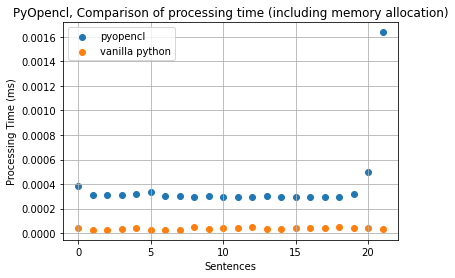

In [39]:
if __name__ == "__main__":
    main()